# Import dependencies

In [1]:
import math
from scipy import integrate
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits import mplot3d


# Parameters

In [ ]:
flowRateSludge = 36 #kg/hr
flowRateAir = 7.2
flowRateSyngas = 40

# Fugacity Calculations

In [ ]:
def betaSpecies(T,Tc,w,P,Pc):
  # get Tcij, Pcij, wij from Appendix B
  # K, K, unitless, bar, bar
  
  Tr = T/Tc # Kelvin
  Pr = P/Pc # bar
  B0 = 0.083 - (0.422/(Tr**1.6)) #no dim
  B1 = 0.139 - (0.172/(Tr**4.2)) # no dim
  Bhat = B0 + w*B1 #no dim
  B = Bhat*(Tc/(Pc*10**5))*8.314 # m3/mol
  phiPureSpecies = np.exp(Bhat*(Pr/Tr))
  y1 = 1
  fugacity = phiPureSpecies*y1*P #bar
  return Bhat, phiPureSpecies,B,fugacity

## Z (compressibility factor) calculations

In [ ]:
betaSpecies(600,33.19,-0.216,10,13.13)[2]*10**6

10.269698317745918

In [ ]:
def z(T,Tc,w,P,Pc,y):
  # 1 + Br*Pr/Tr
  beta = betaSpecies(T,Tc,w,P,Pc)[2] #m3/mol
  Tr = T/Tc # Kelvin
  Pr = P/Pc # bar
  z = 1+(beta*y*P*10**5)/(T)
  molarV = (z*8.314*T)/(P*10**5) #m3/mol
  return z, molarV

In [ ]:
z(273.15,282.3,0.082,1,50.4,1)[1]

0.021290161637367667

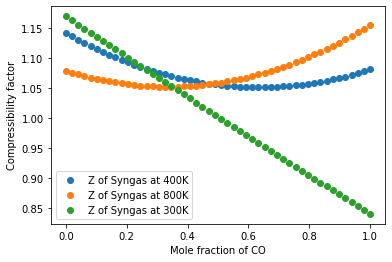

1.0814960442328778

In [ ]:
#zHydrogen = z(3000,33.19,-0.216,10,13.13,0)[0]
#zCO = z(3000,132.9,0.048,10,34.99,1)[0]
y = np.linspace(0,1,50)
zStoreCO = []
zStoreH2 = []
zSyngasD = []
zSyngas = []
zSyngasI = []

for i in range(0,len(y)):
  zs = z(400,132.9,0.048,60,34.99,y[i])[0]
  zsHydrogen = z(400,33.19,-0.216,60,13.13,1-y[i])[0]
  zsyn = y[i]*zs+ (1-y[i])*zsHydrogen
  zStoreCO.append(zs)
  zStoreH2.append(zsHydrogen)
  zSyngas.append(zsyn)

  zsI = z(800,132.9,0.048,60,34.99,y[i])[0]
  zsHydrogenI = z(800,33.19,-0.216,60,13.13,1-y[i])[0]
  zsynI = y[i]*zsI+ (1-y[i])*zsHydrogenI
  zSyngasI.append(zsynI)

  zsD = z(300,132.9,0.048,60,34.99,y[i])[0]
  zsHydrogenD = z(300,33.19,-0.216,60,13.13,1-y[i])[0]
  zsynD = y[i]*zsD+ (1-y[i])*zsHydrogenD
  zSyngasD.append(zsynD)

#plt.scatter(y,zStoreCO,label='Z of CO')
#plt.scatter(y,zStoreH2,label='Z of H2')
plt.scatter(y,zSyngas,label='Z of Syngas at 400K')
plt.scatter(y,zSyngasI,label='Z of Syngas at 800K')
plt.scatter(y,zSyngasD,label='Z of Syngas at 300K')

plt.xlabel('Mole fraction of CO')
plt.ylabel('Compressibility factor')
plt.legend()
plt.show()
z(400,132.9,0.048,60,34.99,1)[0]
#z(300,33.19,-0.216,10,13.13,1)[0]

## Z as a function of T and P

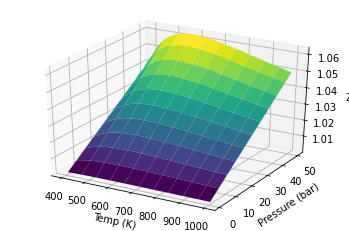

In [ ]:
def f(x, y):
    return 0.6*z(x,132.9,0.048,y,34.99,0.6)[0] + 0.4*z(x,33.19,-0.216,y,13.13,0.4)[0]

x = np.linspace(400,1000,50)
y = np.linspace(1,50,50)
X, Y = np.meshgrid(x, y)
Z = f(X, Y)

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, rstride=5, cstride=5,
                cmap='viridis', edgecolor='none')
ax.set_xlabel('Temp (K)')
ax.set_ylabel('Pressure (bar)')
ax.set_zlabel('Z');


In [ ]:
def zcMix(zi,zj):
  zmix = (zi+zj)/2
  return zmix #dimensionless

def tcMix(Tci,Tcj,kij,chem):
  # K, K , - , bool
  if chem == True:
    kij = 0
  tmix = ((Tci*Tcj)**(1/2))*(1-kij)
  return tmix # K

def wMix(wi,wj):
  wmix = (wi+wj)/2
  return wmix

def vcMix(vi,vj):
  # m3/mol, m3/mol
  vmix = ((vi**(1/3)+vj**(1/3))/2)**3
  return vmix #m3/mol

def pcMix(z,T,V):
  # unitless , K, m3/mol
  pmix = (z*8.314*T)/V
  return pmix #Pa

def mixCorr(T,Tc1,Tc2,w1,w2,P,Pc1,Pc2,Vc1,Vc2,Z1,Z2,y1):
  # volume in m3/mol
  # K, K ,K ,-,-,bar,bar,bar,m3/mol,m3/mol,-,-,%/100
  wmix = wMix(w1,w2)
  tmix = tcMix(Tc1,Tc2,0,True)
  vmix = vcMix(Vc1,Vc2)
  zmix = zcMix(Z1,Z2)
  pmix = pcMix(zmix,tmix,vmix) # Pascal
  bhatMix = betaSpecies(T,tmix,wmix,P,pmix*10**-5)[0] # no dim
  b12 = betaSpecies(T,tmix,wmix,P,pmix*10**-5)[2] #M3/MOL
  b11 = betaSpecies(T,Tc1,w1,P,Pc1)[2] #M3/MOL
  b22 = betaSpecies(T,Tc2,w2,P,Pc2)[2] #M3/MOL
  sigmaMix = 2*b12 - b11 - b22 #M3/MOL
  phiHat1 = math.exp( ((P*10**5)/(8.314*T))*(b11+((1-y1)**2)*sigmaMix) )
  phiHat2 = math.exp( ((P*10**5)/(8.314*T))*(b22+((y1)**2)*sigmaMix) )
  fugacityHat1 = phiHat1*y1*P #bar
  fugacityHat2 = phiHat2*(1-y1)*P #bar
  return bhatMix, b12, phiHat1,fugacityHat1,phiHat2,fugacityHat2

In [ ]:
#TEST to see if an increase in y1 results in an increase in partial fugacity for ethylene (1) and ethane gas mixture (2)
mixCorr(273.15,282.3,305.3,0.087,0.1,1,50.4,48.72,131*10**-6,145.5*10**-6,0.281,0.279,0.9)[3]-mixCorr(273.15,282.3,305.3,0.087,0.1,1,50.4,48.72,131*10**-6,145.5*10**-6,0.281,0.279,0.5)[3] > 0

True

In [ ]:
mixCorr(600,132.9,33.19,0.048,-0.216,60,34.99,13.13,93.4*10**-6,64.1*10**-6,0.299,0.305,0.6)[4]

1.0140534418519151

1.0140534418519151

## Pressure range and its effect on fugacity of gas mixture

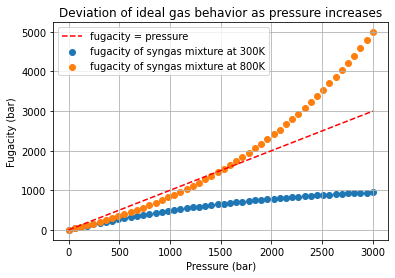

In [ ]:
plin = np.linspace(0,3000,50)
phistore = []
fugstore = []
phistoreI = []
fugstoreI = []
for i in range(0,len(plin)):
  philin = mixCorr(300,132.9,33.19,0.048,-0.216,plin[i],34.99,13.13,93.4*10**-6,64.1*10**-6,0.299,0.305,0.6)[2]
  fuglin = mixCorr(300,132.9,33.19,0.048,-0.216,plin[i],34.99,13.13,93.4*10**-6,64.1*10**-6,0.299,0.305,0.6)[3]
  phistore.append(philin)
  fugstore.append(fuglin)

  philinI = mixCorr(600,132.9,33.19,0.048,-0.216,plin[i],34.99,13.13,93.4*10**-6,64.1*10**-6,0.299,0.305,0.6)[2]
  fuglinI = mixCorr(600,132.9,33.19,0.048,-0.216,plin[i],34.99,13.13,93.4*10**-6,64.1*10**-6,0.299,0.305,0.6)[3]
  phistoreI.append(philinI)
  fugstoreI.append(fuglinI)

plt.scatter(plin,fugstore,label='fugacity of syngas mixture at 300K')
plt.scatter(plin,fugstoreI,label='fugacity of syngas mixture at 800K')

plt.plot(plin,plin,'r--',label="fugacity = pressure")
plt.xlabel('Pressure (bar)')
plt.ylabel('Fugacity (bar)')
plt.title('Deviation of ideal gas behavior as pressure increases')
plt.legend()
plt.grid()
plt.show()

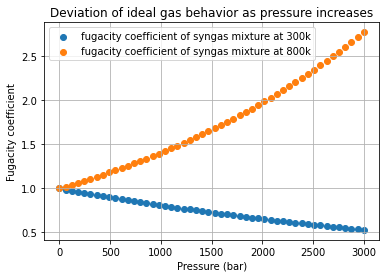

In [ ]:
plt.scatter(plin,phistore,label='fugacity coefficient of syngas mixture at 300k')
plt.scatter(plin,phistoreI,label='fugacity coefficient of syngas mixture at 800k')

plt.xlabel('Pressure (bar)')
plt.ylabel('Fugacity coefficient')
plt.title('Deviation of ideal gas behavior as pressure increases')
plt.legend()
plt.grid()
plt.show()

In [ ]:
def binary(P,T,b11,b22,b12,y1):
  # p is bar, b
  sigmaMix = 2*b12 - b11 - b22
  sigma = sigmaMix*(10**-6)
  phiHat1 = math.exp( ((P*10**5)/(8.314*T))*(b11*(10**-6)+((1-y1)**2)*sigma) )
  phiHat2 = math.exp( ((P*10**5)/(8.314*T))*(b22*(10**-6)+((y1)**2)*sigma) )
  return phiHat1, phiHat2, sigma

# Exergy and Energy Balances

In [ ]:
def capacity(A,B,C,D,T):
  cp = (A + (B*10**-3)*T +(C*10**-6)*T**2 + (D*10**5)*T**-2)*8.314
  return cp 

In [ ]:
def cp(T,T0,A,B,C,D):
  cpH = A+ (B/2)*(T+T0) + (C/3)*(T**2 + T0**2 + T*T0) + (D/(T*T0))
  cpH = 8.314*cpH

  cpS = A + ((B+(C+ (D/((T0**2)*(T**2))))*((T+T0)/2))*((T-T0)/math.log(T/T0)))
  cpS = 8.314*cpS
  
  return cpH, cpS

In [ ]:
10985/113841

0.09649423318488067

In [ ]:
y = [0.0901,0.5978,0.3098,0.0430]
mass = [44,28,2,16]
A = [5.457,3.376,3.249,1.702]
B = [1.045*10**-3,0.557*10**-3,0.422*10**-3, 9.081*10**-3]
C = [0,0,0,-2.164*10**-6]
D = [-1.157*10**5,-0.031*10**5,0.083*10**5,0]
T = 1000
T0 = 298.15
storeCPH = []
storeCPS = []
sum1 = []
for i in range(0,len(A)):
  storeCPH.append(cp(T,T0,A[i],B[i],C[i],D[i])[0])
  storeCPS.append(cp(T,T0,A[i],B[i],C[i],D[i])[1])
for i in range(0,len(A)):
  sum1.append(y[i]*mass[i])
(40*1000)/(3600*sum(sum1))

0.5048118667135133

In [ ]:
def standardHeat(temp):
  # [C0, C02]
  href = [172.5, -41]
  A = [3.376,5.457]
  B = [0.557*10**-3, 1.045*10**-3]
  C = [0,0]
  D = [-0.031*10**5, -1.157*10**5]
  R1 = []
  R2 = []

  # Boudouard Reaction
  deltaA1 = 2*A[0]-A[1]
  deltaB1 = 2*B[0]-B[1]
  deltaC1 = 2*C[0]-C[1]
  deltaD1 = 2*D[0]-D[1]
  R1 = [deltaA1,deltaB1,deltaC1,deltaD1]
  # Shift Reaction
  deltaA2 = A[1]-A[0]-3.470
  deltaB2 = B[1]-B[0]-(1.450*10**-3)
  deltaC2 = C[1]-C[0]
  deltaD2 = D[1]-D[0]-(0.121*10**5)
  R2 = [deltaA2,deltaB2,deltaC2,deltaD2]

  cp1 = lambda T: (R1[0] + R1[1]*T +R1[2]*T**2 + R1[3]*T**-2)*8.314
  cpInt1 = integrate.quad(cp1,298.15,temp)[0]
  cp2 = lambda T: (R2[0] + R2[1]*T +R2[2]*T**2 + R2[3]*T**-2)*8.314
  cpInt2 = integrate.quad(cp2,298.15,temp)[0]

  h1 = (href[0]+ cpInt1)*10**-3
  h2 = (href[1]+ cpInt2)*10**-3

  return h1,h2

In [ ]:
ySyngas = [0.3098,0.0901,0.5978,0.0403] #h2,co2,co,ch4
massGas = [2,44,28,16]
h0gas = [0,-394374,-137150,-74850]
h0syngas = [0,0,0,0]
molarM = [0,0,0,0]

for i in range(0,len(ySyngas)):
  h0syngas[i] = ySyngas[i]*h0gas[i]
  molarM[i] = ySyngas[i]*massGas[i] #g/mol

h0SYNGAS = sum(h0syngas)
molarMassSyngas = sum(molarM)

In [ ]:
def exergyChemical(n,ex):
  exergyChemical = []
  exergyChemical2 = []
  for i in range(0,len(n)):
    exergyChem = n[i]*math.log(n[i])
    exergyChem2 = n[i]*ex[i]
    exergyChemical.append(exergyChem)
    exergyChemical2.append(exergyChem2)
  return (8.314*273.15)*sum(exergyChemical) + sum(exergyChemical2)

n = ySyngas
ex = [236100,19870,275100,831650] #kJ/kmol
chemicalExergySyngas = exergyChemical(n,ex)

nAir = [0.21,0.79]
exAir = [3970,668]
chemicalExergyAir = exergyChemical(nAir,exAir)

In [ ]:
def exergyPhysical(A,B,C,D,temp):
  exergyStore = []
  for i in range(0,len(A)):
    cpH = lambda T: (A[i] + (B[i]*10**-3)*T +(C[i]*10**-6)*T**2 + (D[i]*10**5)*T**-2)*8.314 #J/mol
    deltaH = integrate.quad(cpH,298.15,temp)[0]
    cpS = lambda T: ((A[i]/T) + (B[i]*10**-3) +(C[i]*10**-6)*T + (D[i]*10**5)*T**-3)*8.314 #J/mol
    deltaS = integrate.quad(cpS,298.15,temp)[0] - (8.314*4.09)
    exergyPh = deltaH - 298.15*(deltaS)
    exergyStore.append(exergyPh)
  return exergyStore

Asyngas = [3.249,5.457,3.376,1.702] # H2, CO2, CO, CH4
Bsyngas = [0.422,1.045,0.557,9.081]
Csyngas = [0,0,0,-2.164]
Dsyngas = [0.083,-1.157,-0.031,0]

exergyPhysicalSyngas = exergyPhysical(Asyngas, Bsyngas, Csyngas, Dsyngas,1000)
syngasPhysicalExergy = sum(exergyPhysicalSyngas)

Aair = [3.355]
Bair = [0.575]
Cair = [0]
Dair = [-0.016]

exergyPhysicalAir = exergyPhysical(Aair, Bair, Cair, Dair,1000)
exergyPhysicalAir = sum(exergyPhysicalAir)

In [ ]:
exergyTotalSyngas = (flowRateSyngas*10**-3*1000*(chemicalExergySyngas + syngasPhysicalExergy))/(3600*molarMassSyngas) #kJ/s
exergyTotalAir = ((chemicalExergyAir+exergyPhysicalAir)*1000*flowRateAir*10**-3)/(3600*29) #kJ/s
exergyTotalSludge = (1.156*17*flowRateSludge*10**3)/3600 #kJ/s
exergy = [exergyTotalSyngas,exergyTotalAir,exergyTotalSludge]
exergy

[186.5499810613931, 1.4490950630451043, 196.51999999999998]

## Exergy and energy efficiencies across temperature range and air flow rate range


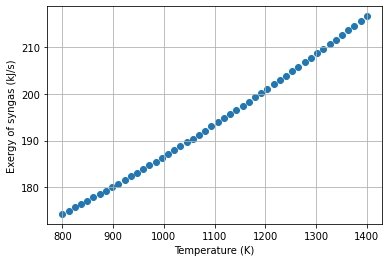

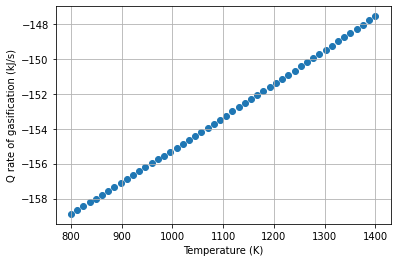

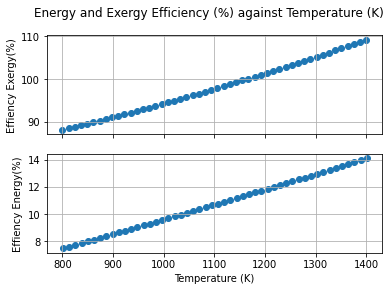

[-158.87961820786865, -158.66035657042625, -158.4405789145003, -158.22028758976776, -157.99948488803807, -157.7781730473666, -157.5563542558228, -157.33403065494525, -157.11120434291425, -156.88787737746839, -156.6640517785886, -156.43972953097145, -156.21491258631045, -155.98960286540262, -155.7638022600957, -155.5375126350901, -155.31073582960764, -155.0834736589389, -154.8557279158792, -154.62750037206214, -154.39879277919954, -154.16960687023544, -153.9399443604203, -153.70980694831277, -153.47919631671374, -153.24811413353868, -153.01656205263248, -152.78454171453131, -152.5520547471758, -152.3191027665784, -152.0856873774492, -151.85181017378238, -151.61747273940688, -151.382676648503, -151.14742346608838, -150.9117147484744, -150.67555204369577, -150.43893689191515, -150.20187082580372, -149.96435537090048, -149.7263920459506, -149.4879823632251, -149.24912782882217, -149.00982994295228, -148.7700902002074, -148.5299100898155, -148.2892910958816, -148.0482346976157, -147.8067423

In [ ]:
def tempRange(flowRateSyngas,molarMassSyngas,chemicalExergySyngas,chemicalExergyAir,flowRateAir):
  T = np.linspace(800,1400,50)
  store = []
  storeAir = []
  Aair = [3.355]
  Bair = [0.575]
  Cair = [0]
  Dair = [-0.016]
  Asyngas = [3.249,5.457,3.376,1.702] # H2, CO2, CO, CH4
  Bsyngas = [0.422,1.045,0.557,9.081]
  Csyngas = [0,0,0,-2.164]
  Dsyngas = [0.083,-1.157,-0.031,0]
  ySyngas = [0.3098,0.0901,0.5978,0.0403]

  storeSyngasH = []
  storeAirH = []
  qStore = []
  for i in range(0,len(T)):
    exergyT = exergyPhysical(Asyngas, Bsyngas, Csyngas, Dsyngas,T[i])
    syngasPhysicalExergy = sum(exergyT)
    syngasTotal = (flowRateSyngas*10**-3*1000*(chemicalExergySyngas + syngasPhysicalExergy))/(3600*molarMassSyngas) #kJ/s
    store.append(syngasTotal)

    exergyA = exergyPhysical(Aair, Bair, Cair, Dair,T[i])
    airPhysicalExergy = sum(exergyA)
    exergyTotalAir = ((chemicalExergyAir+airPhysicalExergy)*1000*flowRateAir*10**-3)/(3600*29) #kJ/s
    storeAir.append(exergyTotalAir)
  
    indivEnthalpSyngas = finalEnthalpy(Asyngas,Bsyngas,Csyngas,Dsyngas,T[i],[8468,9364,8669,0])
    ans = [0,0,0,0]
    for i in range(0,len(indivEnthalpSyngas)):
      ans[i] = ySyngas[i]*indivEnthalpSyngas[i]
    finalEnthalpySyngas = sum(ans) #J/mol
    hSyngas = (finalEnthalpySyngas*flowRateSyngas*1000*10**-3)/(3600*molarMassSyngas) #kJ/s
    storeSyngasH.append(hSyngas)

    finalEnthalpyAir = finalEnthalpy(Aair,Bair,Bair,Dair,T[i],[8687.53])
    hAir = (finalEnthalpyAir[0]*flowRateAir*1000*10**-3)/(3600*29)
    storeAirH.append(hAir)

  storeSludge = np.ones(len(T))
  storeSludgeH = np.ones(len(T))
  for i in range(0,len(storeSludge)):
    storeSludge[i] = (1.156*17*36*10**3)/3600
    storeSludgeH[i] = (17*36*10**3)/3600 #kJ/s

  storeEff = []
  storeEffH = []
  for i in range(0,len(storeAir)):
    eff = (store[i]/(storeSludge[i]+storeAir[i]))*100
    effH = (storeSyngasH[i]/(storeSludgeH[i]+storeAirH[i]))*100
    storeEff.append(eff)
    storeEffH.append(effH)

  for i in range(0,len(storeSyngasH)):
    q = storeSyngasH[i]-storeAirH[i]-storeSludgeH[i]
    qStore.append(q)
  return store,storeAir,storeEff,storeEffH,storeSyngasH,storeAirH,qStore


T = np.linspace(800,1400,50)
y1 = tempRange(flowRateSyngas,molarMassSyngas,chemicalExergySyngas,chemicalExergyAir,flowRateAir)[0]
plt.scatter(T,y1)
plt.xlabel('Temperature (K)')
plt.ylabel('Exergy of syngas (kJ/s)')
plt.grid()
plt.show()

y4 = tempRange(flowRateSyngas,molarMassSyngas,chemicalExergySyngas,chemicalExergyAir,flowRateAir)[6]
plt.scatter(T,y4)
plt.xlabel('Temperature (K)')
plt.ylabel('Q rate of gasification (kJ/s)')
plt.grid()
plt.show()

fig, (ax1, ax2) = plt.subplots(2,sharex=True)
fig.suptitle('Energy and Exergy Efficiency (%) against Temperature (K)')
y2 = tempRange(flowRateSyngas,molarMassSyngas,chemicalExergySyngas,chemicalExergyAir,flowRateAir)[2]
y3 = tempRange(flowRateSyngas,molarMassSyngas,chemicalExergySyngas,chemicalExergyAir,flowRateAir)[3]
ax1.scatter(T,y2)
ax1.grid()
plt.setp(ax1, ylabel='Effiency Exergy(%)')

ax2.scatter(T+1,y3)
plt.setp(ax2, ylabel='Effiency Energy(%)')
plt.xlabel('Temperature (K)')
ax2.grid()
plt.show()

print(tempRange(flowRateSyngas,molarMassSyngas,chemicalExergySyngas,chemicalExergyAir,flowRateAir)[6])

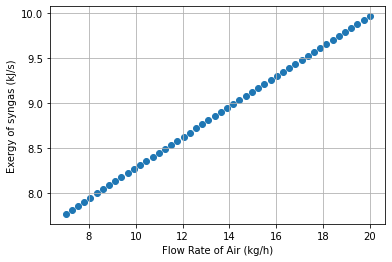

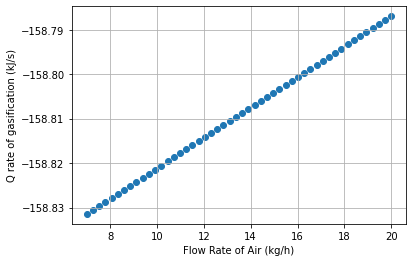

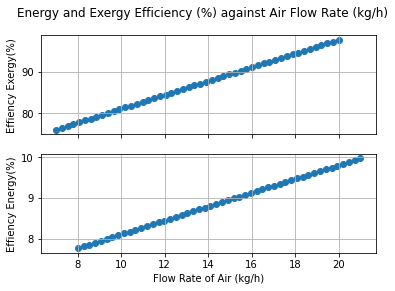

In [ ]:
def afrRange(flowRateSyngas,molarMassSyngas,chemicalExergySyngas,chemicalExergyAir,T):
  flowRateAir = np.linspace(7,20,50)
  store = []
  storeAir = []
  Aair = [3.355]
  Bair = [0.575]
  Cair = [0]
  Dair = [-0.016]
  Asyngas = [3.249,5.457,3.376,1.702] # H2, CO2, CO, CH4
  Bsyngas = [0.422,1.045,0.557,9.081]
  Csyngas = [0,0,0,-2.164]
  Dsyngas = [0.083,-1.157,-0.031,0]
  ySyngas = [0.3098,0.0901,0.5978,0.0403]

  storeSyngasH = []
  storeAirH = []
  qStore = []

  for i in range(0,len(flowRateAir)):
    exergyT = exergyPhysical(Asyngas, Bsyngas, Csyngas, Dsyngas,T)
    syngasPhysicalExergy = sum(exergyT)
    syngasTotal = (0.75*(36+flowRateAir[i])*10**-3*1000*(chemicalExergySyngas + syngasPhysicalExergy))/(3600*molarMassSyngas) #kJ/s
    store.append(syngasTotal)

    exergyA = exergyPhysical(Aair, Bair, Cair, Dair,T)
    airPhysicalExergy = sum(exergyA)
    exergyTotalAir = ((chemicalExergyAir+airPhysicalExergy)*1000*flowRateAir[i]*10**-3)/(3600*29) #kJ/s
    storeAir.append(exergyTotalAir)
  
    indivEnthalpSyngas = finalEnthalpy(Asyngas,Bsyngas,Csyngas,Dsyngas,T,[8468,9364,8669,0])
    ans = [0,0,0,0]
    for j in range(0,len(indivEnthalpSyngas)):
      ans[j] = ySyngas[j]*indivEnthalpSyngas[j]
    finalEnthalpySyngas = sum(ans) #J/mol
    hSyngas = finalEnthalpySyngas*(0.75*(36+flowRateAir[i])*1000*10**-3)/(3600*molarMassSyngas) #kJ/s
    storeSyngasH.append(hSyngas)

    finalEnthalpyAir = finalEnthalpy(Aair,Bair,Bair,Dair,T,[8687.53])
    hAir = (finalEnthalpyAir[0]*flowRateAir[i]*1000*10**-3)/(3600*29)
    storeAirH.append(hAir)

  storeSludge = np.ones(len(flowRateAir))
  storeSludgeH = np.ones(len(flowRateAir))
  for i in range(0,len(storeSludge)):
    storeSludge[i] = (1.156*17*36*10**3)/3600
    storeSludgeH[i] = (17*36*10**3)/3600 #kJ/s

  storeEff = []
  storeEffH = []
  for i in range(0,len(storeAir)):
    eff = (store[i]/(storeSludge[i]+storeAir[i]))*100
    effH = (storeSyngasH[i]/(storeSludgeH[i]+storeAir[i]))*100
    storeEff.append(eff)
    storeEffH.append(effH)

  for i in range(0,len(storeSyngasH)):
    q = storeSyngasH[i]-storeAirH[i]-storeSludgeH[i]
    qStore.append(q)

  return store,storeAir,storeEff,storeEffH,storeSyngasH,storeAirH,qStore

fra = np.linspace(7,20,50)
y1 = afrRange(flowRateSyngas,molarMassSyngas,chemicalExergySyngas,chemicalExergyAir,1000)[3]
plt.scatter(fra,y1)
plt.xlabel('Flow Rate of Air (kg/h)')
plt.ylabel('Exergy of syngas (kJ/s)')
plt.grid()
plt.show()

y4 = afrRange(flowRateSyngas,molarMassSyngas,chemicalExergySyngas,chemicalExergyAir,1000)[6]
plt.scatter(fra,y4)
plt.xlabel('Flow Rate of Air (kg/h)')
plt.ylabel('Q rate of gasification (kJ/s)')
plt.grid()
plt.show()

fig, (ax1, ax2) = plt.subplots(2,sharex=True)
fig.suptitle('Energy and Exergy Efficiency (%) against Air Flow Rate (kg/h)')
y2 = afrRange(flowRateSyngas,molarMassSyngas,chemicalExergySyngas,chemicalExergyAir,1000)[2]
y3 = afrRange(flowRateSyngas,molarMassSyngas,chemicalExergySyngas,chemicalExergyAir,1000)[3]
ax1.scatter(fra,y2)
ax1.grid()
plt.setp(ax1, ylabel='Effiency Exergy(%)')

ax2.scatter(fra+1,y3)
plt.setp(ax2, ylabel='Effiency Energy(%)')
plt.xlabel('Flow Rate of Air (kg/h)')
ax2.grid()
plt.show()

In [ ]:
def finalEnthalpy(A,B,C,D,temp,h0):
  change = []
  hStore = []
  for i in range(0,len(A)):
    cpH = lambda T: (A[i] + (B[i]*10**-3)*T +(C[i]*10**-6)*T**2 + (D[i]*10**5)*T**-2)*8.314 #J/mol
    deltaH = integrate.quad(cpH,298.15,temp)[0]
    change.append(deltaH)
    h = h0[i]+deltaH
    hStore.append(h)
  return hStore

indivEnthalpSyngas = finalEnthalpy(Asyngas,Bsyngas,Csyngas,Dsyngas,1000,[8468,9364,8669,0])
ans = [0,0,0,0]
for i in range(0,len(indivEnthalpSyngas)):
  ans[i] = ySyngas[i]*indivEnthalpSyngas[i]
finalEnthalpySyngas = sum(ans) #J/mol

finalEnthalpyAir = finalEnthalpy(Aair,Bair,Bair,Dair,1000,[8687.53])


In [ ]:
hSyngas = (finalEnthalpySyngas*flowRateSyngas*1000*10**-3)/(3600*molarMassSyngas) #kJ/s
hSludge = (17*flowRateSludge*10**3)/3600 #kJ/s
hAir = (finalEnthalpyAir[0]*flowRateAir*1000*10**-3)/(3600*29)
energy = [hSyngas, hAir,hSludge]
energy

[16.510545613095214, 2.204298338325147, 170.0]

In [ ]:
deltaExergy = exergy[0]-exergy[1]-exergy[2]
effExergy = 1-(abs(deltaExergy)/(exergy[1]+exergy[2]))
effEnergy = energy[0]/(energy[1]+energy[2])
effExergy

0.9423187038460956

# Mean Capacity Calculations

In [7]:
cA = 1.702-2*(3.249)
cB = (10**-3)*(9.081-2*(0.422))
cC = (10**-6)*(-2.164)
cD = (10**5)*(0-0.083)
T = 1000
T0 = 298.15
ans1 = cA*(T-T0) + (cB/2)*(T**2 -T0**2) + (cC/3)*(T**3 - T0**3) + cD*((T-T0)/(T*T0))
ans1 = 8.314*ans1*10**-3 - 75
ans1

-77.78879760246328